# Decision Trees

## Training and visualizing a Decision Tree
Decision trees (TDs) usually do not require any special feature scaling before training.

In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:]  # petal lenght and width
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(max_depth=2)

There's a handy function `export_graphviz` to export a trained DT in a `.dot` format which can be converted into `.pdf` or `.png` with a command line tool as follows:
```bash
dot -Tpng data/iris_tree.dot -o data/iris_tree.png
```

In [2]:
!mkdir -p ./data

from sklearn.tree import export_graphviz

export_graphviz(
    tree_clf,
    out_file='data/iris_tree.dot',
    feature_names=iris.feature_names[2:],
    class_names=iris.target_names,
    rounded=True,
    filled=True,
)

## Making predictions

In [3]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [4]:
tree_clf.predict([[5, 1.5]])

array([1])

### Regression
DTs can also perform regression. The algorithm is almost the same with few adjustments:
* Predicted value in a leaf node is a statistic (usually a mean) of the training samples that fall in that leaf node
* the cost function is *MSE* instead of *Gini impurity* or *Information gain (entropy)*

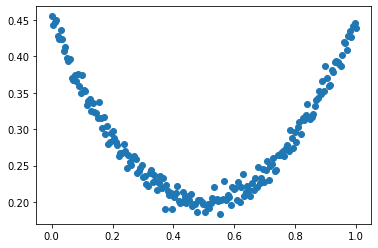

In [5]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

np.random.seed(42)

noise = 0.01 * np.random.randn(200) + 0.2

X = np.linspace(0, 1, 200, dtype=np.float)
y = (X - 0.5)**2 + noise

plt.scatter(X, y)
plt.show()

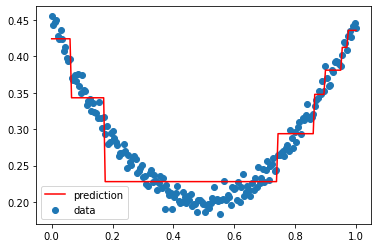

In [6]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=3)
tree_reg.fit(X[:, np.newaxis], y)

y_predict = tree_reg.predict(X[:, np.newaxis])

plt.scatter(X, y, label='data')
plt.plot(X, y_predict, 'r-', label='prediction')
plt.legend()
plt.show()

Other forms of regularization other than `max_depth` can be for instance `min_samples_leaf` that specifies the minimum number of examples that any leaf node must have.

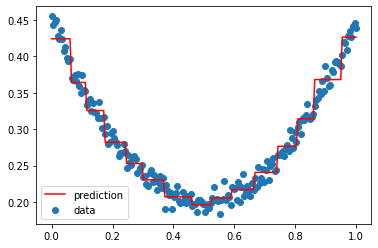

In [7]:
tree_reg = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg.fit(X[:, np.newaxis], y)

y_predict = tree_reg.predict(X[:, np.newaxis])

plt.scatter(X, y, label='data')
plt.plot(X, y_predict, 'r-', label='prediction')
plt.legend()
plt.show()

## Exercise on moons dataset

In [8]:
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline

X, y = make_moons(n_samples=10_000, noise=0.4)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

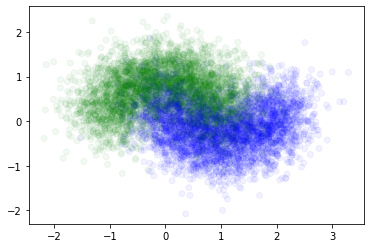

In [9]:
color_train = ['b' if t else 'g' for t in y_train]

plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.05, color=color_train)
plt.show()

train accuracy: 0.981375


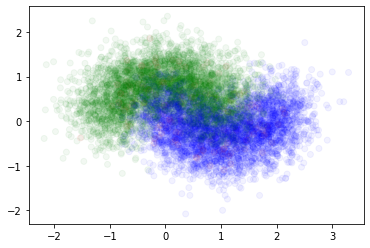

In [10]:
dt = DecisionTreeClassifier(max_leaf_nodes=1_000)
dt.fit(X_train, y_train)

y_train_predict = dt.predict(X_train)

color_train_predict = [
    color_train[i] if correct else 'r'
    for i, correct in enumerate(y_train == y_train_predict)
]

train_accuracy = accuracy_score(y_train, y_train_predict)
print('train accuracy: %f' % train_accuracy)

plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.05, color=color_train_predict)
plt.show()

best CV score: 0.854750
best params: {'max_depth': 2, 'max_leaf_nodes': 1000}
train accuracy: 0.856250


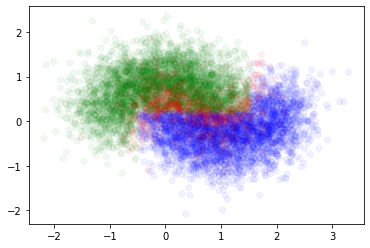

In [11]:
model = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=[
        {'max_leaf_nodes': list(range(800, 1600, 100)), 'max_depth': [None]},
        {'max_leaf_nodes': [1000, 1500, 2000], 'max_depth': [2, 5, 10]},
        {'max_leaf_nodes': list(range(900, 1100, 50)), 'max_depth': [2]},
        {'max_leaf_nodes': [500, 1000, 1500], 'max_depth': [2], 'min_samples_leaf': [5, 10, 15, 20]},
    ],
)

model.fit(X_train, y_train)

print('best CV score: %f' % model.best_score_)
print('best params: %s' % model.best_params_)

y_train_predict = model.predict(X_train)

train_accuracy = accuracy_score(y_train, y_train_predict)
print('train accuracy: %f' % train_accuracy)

color_train_predict = [
    color_train[i] if correct else 'r'
    for i, correct in enumerate(y_train == y_train_predict)
]

plt.scatter(X_train[:, 0], X_train[:, 1], alpha=0.05, color=color_train_predict)
plt.show()

test accuracy: 0.857000


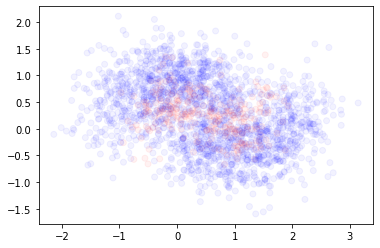

In [12]:
y_test_predict = model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_test_predict)
print('test accuracy: %f' % test_accuracy)

plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.05, color=['b' if correct else 'r' for correct in y_test == y_test_predict])
plt.show()

## Random Forest exercise

In [13]:
from scipy import stats
from sklearn.model_selection import ShuffleSplit

params = model.best_params_
print(f'params: {params}')

forest = []
accuracies = []

rs = ShuffleSplit(n_splits=1000)

for train_index, _ in rs.split(X_train):
    dt = DecisionTreeClassifier(**params)
    dt.fit(X_train[train_index, :], y_train[train_index])
    accuracies.append(dt.score(X_test, y_test))
    forest.append(dt)
    
accuracies = np.array(accuracies)
stats.describe(accuracies)

params: {'max_depth': 2, 'max_leaf_nodes': 1000}


DescribeResult(nobs=1000, minmax=(0.856, 0.8625), mean=0.8571195, variance=2.777474974974897e-07, skewness=2.329293782196337, kurtosis=14.956698386084287)

test accuracy: 0.857000


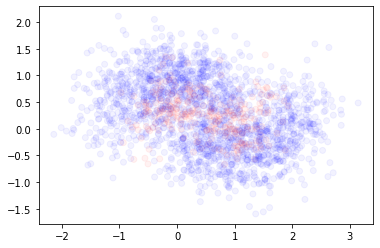

In [20]:
def predict(model, X):
    predictions = np.stack([dt.predict(X) for dt in model], axis=1)  # shape: (rows(X), num_trees)
    y = stats.mode(predictions, axis=1).mode  # use majority vote over DTs in the model
    return np.squeeze(y)

y_test_predict = predict(forest, X_test)

test_accuracy = accuracy_score(y_test, y_test_predict)
print('test accuracy: %f' % test_accuracy)

plt.scatter(X_test[:, 0], X_test[:, 1], alpha=0.05, color=['b' if correct else 'r' for correct in y_test == y_test_predict])
plt.show()